# ALeRCE API retrieval examples

Load libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os, sys

import requests
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import pandas as pd
import seaborn as sns
#from pandas.io.json import json_normalize

#from collections import OrderedDict

from astropy.time import Time
from datetime import datetime
from IPython.display import HTML

import astropy.units as u
from astropy import coordinates

#from astroquery.ned import Ned
#from astroquery.simbad import Simbad
#from astropy.time import Time

#import json

from alerce.api import AlerceAPI

#!pip install psycopg2-binary
import psycopg2

from io import StringIO

/home/rodrigo/anaconda3/envs/tf1/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import time
from astropy.time import Time

In [4]:
now = Time(datetime.utcnow(), scale='utc').datetime
now_mjd = Time(datetime.utcnow(), scale='utc').mjd

# Get fresh list of SNe sent to TNS by ALeRCE

In [5]:
def dourl(searchweb, searchoptions):
    url = searchweb
    for key in searchoptions.keys():
        url = "%s&%s=%s" % (url, key, searchoptions[key])
    return url

In [6]:
def get_tns_df(searchoptions):
    urlpage = dourl(searchweb,searchoptions)
    print(urlpage)
    s = requests.Session()
    response = s.get(urlpage)
    response.close()
    df = pd.read_csv(StringIO(response.text))
    urls = [f"http://alerce.online/object/{oid}" for oid in df['Disc. Internal Name']]
    df['url'] = urls
    return df

In [7]:
searchweb = "https://wis-tns.weizmann.ac.il/search?"
searchoptions = {
    "reporting_groupid[]": 74, # ALeRCE
    #"groupid": 74,
    #"discovery_data_source_id" : "48", # ZTF
    "num_page" : 500,  # 500 number of rows per page
    "format" : "csv",
    "display[remarks]":1,
}

In [8]:
all_alerce = []
page = 0
while True:
    print("Loading TNS page %i..." % page)
    searchoptions["page"] = page
    temp = get_tns_df(searchoptions)
    all_alerce.append(temp)
    if temp.shape[0] < 500:
        break
    page += 1
all_alerce = pd.concat(all_alerce)

Loading TNS page 0...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=74&num_page=500&format=csv&display[remarks]=1&page=0
Loading TNS page 1...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=74&num_page=500&format=csv&display[remarks]=1&page=1
Loading TNS page 2...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=74&num_page=500&format=csv&display[remarks]=1&page=2
Loading TNS page 3...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=74&num_page=500&format=csv&display[remarks]=1&page=3
Loading TNS page 4...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=74&num_page=500&format=csv&display[remarks]=1&page=4


In [9]:
all_alerce.shape

(2047, 25)

In [10]:
list(all_alerce)

['ID',
 'Name',
 'RA',
 'DEC',
 'Obj. Type',
 'Redshift',
 'Host Name',
 'Host Redshift',
 'Reporting Group/s',
 'Discovery Data Source/s',
 'Classifying Group/s',
 'Associated Group/s',
 'Disc. Internal Name',
 'Disc. Instrument/s',
 'Class. Instrument/s',
 'TNS AT',
 'Public',
 'End Prop. Period',
 'Discovery Mag/Flux',
 'Discovery Filter',
 'Discovery Date (UT)',
 'Sender',
 'Remarks',
 'Ext. catalog/s',
 'url']

In [11]:
sent = list(all_alerce["Disc. Internal Name"].values)

In [12]:
retracted = pd.read_csv("retracted.txt").oid.to_list()

### Remove retracted

In [13]:
all_alerce = all_alerce[~all_alerce["Disc. Internal Name"].isin(retracted)]

In [14]:
all_alerce.to_pickle("all_alerce.pkl")

In [15]:
all_alerce = pd.read_pickle("all_alerce.pkl")

In [16]:
classified_mask = ~(all_alerce["Classifying Group/s"].isna())

In [17]:
np.sum(classified_mask)

301

In [18]:
all_alerce.head()

,ID,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,...,TNS AT,Public,End Prop. Period,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Ext. catalog/s,url
0,55308,AT 2020ecu,04:29:04.947,-12:32:37.37,NaN,NaN,WISEA J042904.89-123236.8,NaN,ALeRCE,ZTF,...,1,1,NaN,19.5933,g-ZTF,2020-03-05 03:24:23.996,ALeRCE,NaN,NaN,http://alerce.online/object/ZTF20aaskdgf
1,55307,AT 2020ect,10:49:59.971,+23:25:53.61,NaN,NaN,SDSS J105000.09+232553.6,0.387000,ALeRCE,ZTF,...,1,1,NaN,18.5449,g-ZTF,2020-03-05 06:38:47.996,ALeRCE,NaN,NaN,http://alerce.online/object/ZTF20aasmgqk
2,55306,AT 2020ecs,12:30:31.750,-17:13:12.76,NaN,NaN,NaN,NaN,ALeRCE,ZTF,...,1,1,NaN,19.3806,r-ZTF,2020-03-05 10:10:47.001,ALeRCE,NaN,NaN,http://alerce.online/object/ZTF20aasoaeu
3,55305,AT 2020ecr,16:49:54.265,+53:56:48.23,NaN,NaN,UGC 10579,0.030308,ALeRCE,ZTF,...,1,1,NaN,18.7305,r-ZTF,2020-03-05 11:56:10.997,ALeRCE,NaN,NaN,http://alerce.online/object/ZTF20aaspdtp
4,55304,AT 2020ecq,02:33:01.352,+21:19:44.06,NaN,NaN,SDSS J023301.36+211945.0,0.046000,ALeRCE,ZTF,...,1,1,NaN,19.1873,g-ZTF,2020-03-05 03:07:37.004,ALeRCE,NaN,NaN,http://alerce.online/object/ZTF20aaskbht


In [19]:
all_alerce[classified_mask]["Obj. Type"].value_counts()


SN Ia                202
SN II                 49
SN IIn                 8
SN Ic                  7
SN Ib                  6
SN IIP                 6
SN Ia-91T-like         5
SN IIb                 3
SN Ic-BL               3
SN                     2
Galaxy                 2
SN Ia-91bg-like        1
SN Iax[02cx-like]      1
TDE                    1
SN Ia-pec              1
AGN                    1
Varstar                1
Name: Obj. Type, dtype: int64

SN Ia                202
SN II                 49
SN IIn                 8
SN Ic                  7
SN Ib                  6
SN IIP                 6
SN Ia-91T-like         5
SN IIb                 3
SN Ic-BL               3
SN                     2
Galaxy                 2
SN Ia-91bg-like        1
SN Iax[02cx-like]      1
TDE                    1
SN Ia-pec              1
AGN                    1
Varstar                1
Name: Obj. Type, dtype: int64


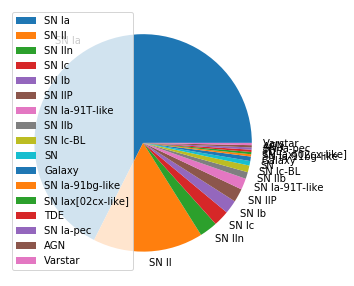

In [20]:
df_SN = all_alerce[classified_mask]["Obj. Type"].value_counts()
print(df_SN)
df_SN.plot.pie(y="count", figsize=(5, 5))
plt.axis("off")
plt.legend()

In [21]:
all_alerce.loc[classified_mask][(all_alerce[classified_mask]["Obj. Type"] == 'SN IIb')]

,ID,Name,RA,DEC,Obj. Type,Redshift,Host Name,Host Redshift,Reporting Group/s,Discovery Data Source/s,...,TNS AT,Public,End Prop. Period,Discovery Mag/Flux,Discovery Filter,Discovery Date (UT),Sender,Remarks,Ext. catalog/s,url
246,49753,SN 2019xct,00:38:50.125,-08:19:04.40,SN IIb,0.03000,SDSS J003849.83-081859.1,0.029000,"ALeRCE, ATLAS, ZTF","ZTF, ATLAS",...,1,1,NaN,18.7863,g-ZTF,2019-12-19 03:01:22.000,ALeRCE,NaN,NaN,http://alerce.online/object/ZTF19aczmnqy
279,49720,SN 2019xbm,13:07:13.988,+58:08:03.35,SN IIb,0.02600,UGC 08205,0.027713,"ALeRCE, ZTF",ZTF,...,1,1,NaN,19.5441,g-ZTF,2019-12-19 13:22:25.000,ALeRCE,NaN,NaN,http://alerce.online/object/ZTF19acyjjni
212,44660,SN 2019pqo,15:41:30.333,+15:47:03.30,SN IIb,0.01413,NGC 5980,0.013649,"ALeRCE, ATLAS","ZTF, ATLAS",...,1,1,NaN,18.6697,r-ZTF,2019-09-07 05:05:53.000,ALeRCE,NaN,NaN,http://alerce.online/object/ZTF19abxqppy


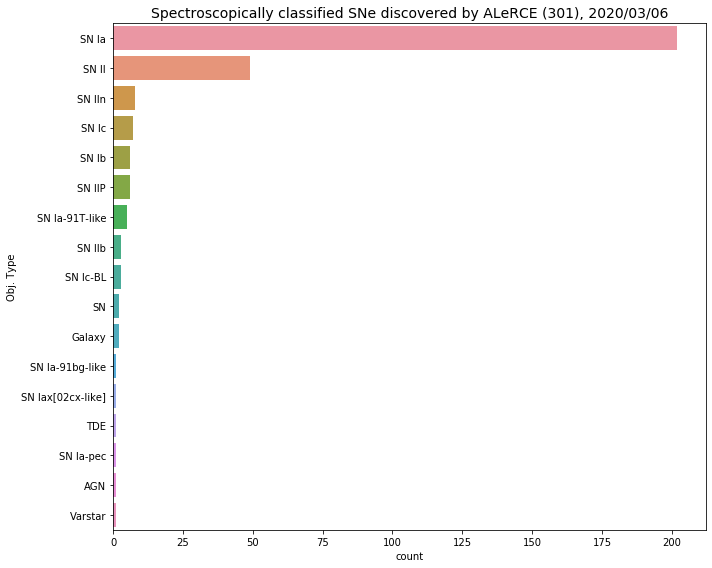

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
#sns.set(style="darkgrid")
counts = all_alerce[classified_mask]["Obj. Type"].value_counts()
sns.countplot(ax=ax, y="Obj. Type", data=all_alerce[classified_mask], order=counts.index)#cl[n.argsort()[::-1]])
ax.set_title("Spectroscopically classified SNe discovered by ALeRCE (%i), %s/%02i/%02i" % 
             (classified_mask.sum(), now.year, now.month, now.day), fontsize=14)
#ax.axvline(2.5, c = 'gray')
plt.tight_layout()
plt.savefig("plots/SN_types.png")

In [23]:
classified_oids = all_alerce[classified_mask]["Disc. Internal Name"].tolist()

In [24]:
oids = [oid for oid in sent if oid not in retracted]
oids = np.array(oids, dtype = str)

# Optional, use all SNe found, not just those in TNS

In [25]:
mode="tns" #'tns' 'all'
if mode == "all":
    oids = []
    for file in os.listdir("candidates"):
        if file[-3:] == 'txt':
            for oid in open("candidates/%s" % file, 'r').readlines():
                oids.append(oid[:-1])
    oids = np.array(oids)
    oids = np.unique(oids)
    oids = [oid for oid in oids if oid not in retracted]
    oids = np.array(oids, dtype = str)
elif mode=="tns":
    oids = [oid for oid in sent if oid not in retracted]
    oids = np.array(oids, dtype = str)

# Run all these cells if you want to update the results

In [26]:
alerce = AlerceAPI()

In [27]:
import json
credentials_file = "../usecases/alercereaduser_v2.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

In [28]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

In [29]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

,tablename
9,asassn
18,class
10,crtsnorth
12,crtssouth
4,detections
23,early_classification_v2
16,features
22,features_v2
2,features_v3
24,ingestion_timestamp


In [30]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

,table,column_name,data_type
0,asassn,ASAS-SN Name,text
1,asassn,Other Names,text
2,asassn,LCID,integer
3,asassn,ra,double precision
4,asassn,dec,double precision
5,asassn,Mean VMag,double precision
6,asassn,Amplitude,double precision
7,asassn,Period,double precision
8,asassn,Type,text
9,asassn,Url,text


In [31]:
query='''
select objects.oid, objects.firstmjd, objects.nobs, objects.meanra, objects.meandec
from objects
where objects.oid in (%s)
''' % ",".join(["'%s'" % oid for oid in oids])
SNe = pd.read_sql_query(query, conn)
SNe.set_index('oid', inplace=True)
SNe.head()

,firstmjd,nobs,meanra,meandec
oid,,,,
ZTF17aaaeqnb,58778.136979,1,19.895777,32.180523
ZTF17aabbxwa,58726.502940,14,80.039296,-17.944241
ZTF17aacqdhh,58846.554456,1,195.458248,43.968051
ZTF17aaddzyk,58803.209572,1,9.765071,-18.608218
ZTF18aaavffc,58789.514595,44,187.979824,32.544519


In [32]:
query='''
select oid, candid, mjd, fid, magpsf, sigmapsf, magpsf_corr, sigmapsf_corr
from detections
where detections.oid in (%s)
''' % ",".join(["'%s'" % oid for oid in oids])
all_detections = pd.read_sql_query(query, conn)
all_detections.set_index('candid', inplace=True)
all_detections.head()

,oid,mjd,fid,magpsf,sigmapsf,magpsf_corr,sigmapsf_corr
candid,,,,,,,
936192433315015010,ZTF19abiijfy,58690.192431,1,19.795248,0.122960,19.795248,0.122960
936168984315015017,ZTF19abiiitl,58690.168981,2,19.884129,0.157709,19.884129,0.157709
937443201415015014,ZTF19abiovio,58691.443206,1,20.032164,0.174063,18.700192,0.078293
936169913315015012,ZTF19abiijfy,58690.169919,2,19.698338,0.136072,19.698338,0.136072
937371221415015020,ZTF19abiovio,58691.371227,2,20.146393,0.212616,19.115045,0.108332


In [33]:
query='''
select oid, fid, diffmaglim, mjd
from non_detections
where non_detections.oid in (%s)
''' % ",".join(["'%s'" % oid for oid in oids])
all_non_detections = pd.read_sql_query(query, conn)
all_non_detections.set_index('mjd', inplace=True)
all_non_detections.head()

,oid,fid,diffmaglim
mjd,,,
58661.191424,ZTF19abiiitl,2,20.485901
58660.232801,ZTF19abiijfy,2,20.829399
58663.190648,ZTF19abiijfy,2,20.358101
58663.211806,ZTF19abiijfy,1,20.739300
58666.171516,ZTF19abiijfy,2,19.855000


# Histogram of cadences

In [34]:
dts = []
dts_1st = []
dts_fid = []
for oid in all_detections.oid.unique():
    mask = (all_detections.oid == oid)
    times = np.sort(np.array(all_detections.loc[mask].mjd.unique()))
    if mask.sum() > 1:
        dts.append(times[1:] - times[:-1])
        dts_1st.append([times[1] - times[0]])
    for fid in [1, 2]:
        mask = (all_detections.oid == oid) & (all_detections.fid == fid)
        times = np.sort(np.array(all_detections.loc[mask].mjd.unique()))
        if mask.sum() > 1:
            dts_fid.append(times[1:] - times[:-1])
dts = np.concatenate(dts)
dts_1st = np.concatenate(dts_1st)
dts_fid = np.concatenate(dts_fid)

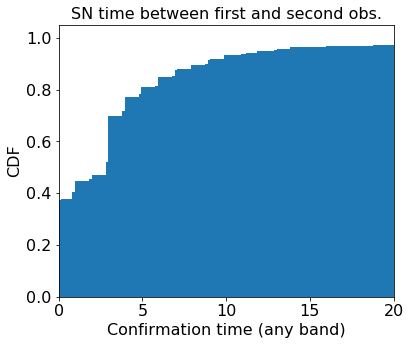

In [35]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(dts_1st, bins=1000, cumulative=True, density=True);
ax.set_xlim(0, 20)
ax.set_xlabel("Confirmation time (any band)", fontsize=16)
ax.set_ylabel("CDF", fontsize=16)
ax.set_title("SN time between first and second obs.", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("plots/SNconfirmation_any_%s.png" % mode)

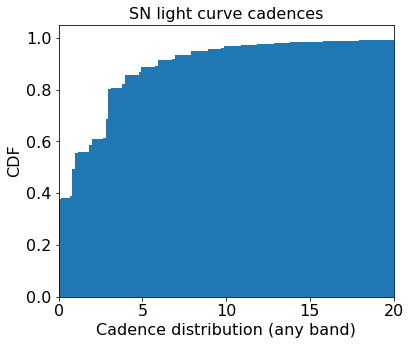

In [36]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(dts, bins=1000, cumulative=True, density=True);
ax.set_xlim(0, 20)
ax.set_xlabel("Cadence distribution (any band)", fontsize=16)
ax.set_ylabel("CDF", fontsize=16)
ax.set_title("SN light curve cadences", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("plots/SNcadence_any_%s.png" % mode)

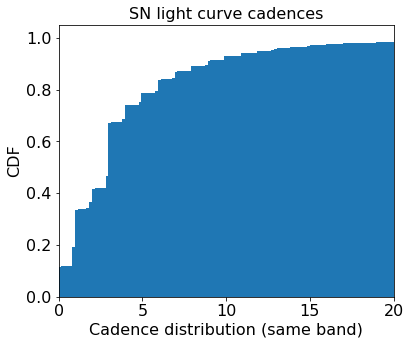

In [37]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(dts_fid, bins=1000, cumulative=True, density=True);
ax.set_xlim(0, 20)
ax.set_xlabel("Cadence distribution (same band)", fontsize=16)
ax.set_ylabel("CDF", fontsize=16)
ax.set_title("SN light curve cadences", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("plots/SNcadence_same_%s.png" % mode)

# Extract relevant features

In [38]:
nobs = []
dts = []
dt2s = []
dmags = []
dts_fid = []
dmags_fid = []
dmdt_fid = []
first_mjds = []
first_det_mags = []
max_mags = []
max_mjds = []
dt_first_max = []
dmag_first_max = []
ras = []; decs = []
reporting_date = []
reporting_time = []

ids_to_drop = []

for SN in oids:#["ZTF19abpsana"]:
    if SN in SNe.index:
        stats = SNe.loc[SN]
    else:
        print("#### skipping SN ####")
        ids_to_drop.append(SN)
        continue
    stats.dropna(inplace=True)
    detections = all_detections[all_detections.oid == SN]
    non_detections = all_non_detections[all_non_detections.oid == SN]
    try:
        nobs.append(int(stats.nobs))
    except:
        print("#### no stats ####")
        print(stats)
        ids_to_drop.append(SN)
        continue
    
    first_det_idx = detections.mjd.idxmin()
    first_det_mjd = float(detections.loc[first_det_idx].mjd)
    first_det_fid = int(detections.loc[first_det_idx].fid)
    first_det_mag = float(detections.loc[first_det_idx].magpsf)
    first_det_mags.append(first_det_mag)
    ras.append(stats.meanra)
    decs.append(stats.meandec)
    first_mjds.append(first_det_mjd)
    max_mjds.append(detections.loc[detections.magpsf.idxmin()].mjd)
    max_mags.append(detections.loc[detections.magpsf.idxmin()].magpsf)
    dt_first_max.append(max_mjds[-1] - first_mjds[-1])
    dmag_first_max.append(first_det_mags[-1] - max_mags[-1])
    
    mask = non_detections.index < first_det_mjd
    if np.sum(mask) > 0:
        last_non_det_mjd = np.array(non_detections.index[mask]).max()
        last_non_det_mag = non_detections.loc[last_non_det_mjd].diffmaglim
        if last_non_det_mag.shape != ():
            last_non_det_mag = last_non_det_mag.unique()[0]
        dts.append(first_det_mjd - last_non_det_mjd)
        dmags.append(last_non_det_mag - first_det_mag)
    else:
        dts.append(None)
        dmags.append(None)

    mask = (non_detections.index < first_det_mjd) & (non_detections.fid == first_det_fid)
    if np.sum(mask) > 0:
        last_non_det_fid_mjd = non_detections.index[mask].max()
        last_non_det_fid_mag = non_detections.loc[last_non_det_fid_mjd].diffmaglim
        if last_non_det_fid_mag.shape != ():
            last_non_det_fid_mag = last_non_det_fid_mag.unique()[0]
        dts_fid.append(first_det_mjd - last_non_det_fid_mjd)
        dmags_fid.append(last_non_det_fid_mag - first_det_mag)
        dmdt_fid.append(dmags_fid[-1] / dts_fid[-1])
    else:
        dts_fid.append(None)
        dmags_fid.append(None)
        dmdt_fid.append(None)
    
    if nobs[-1] > 1:
        second_det_mjd = detections.mjd[detections.mjd > first_det_mjd].min()
        dt2s.append(second_det_mjd - last_non_det_mjd)
    else: 
        dt2s.append(None)
        
    print(SN, nobs[-1], dts[-1], dt2s[-1], dmags[-1], dmags_fid[-1], dt_first_max[-1])
    

/home/rodrigo/anaconda3/envs/tf1/lib/python3.7/site-packages/pandas/core/series.py:4494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


ZTF20aaskdgf 1 8.96976849999919 None 0.3145351409912003 0.528034210205 0.0
ZTF20aasmgqk 1 0.041782399799558334 None 1.3059978485106996 1.5618972778319993 0.0
ZTF20aasoaeu 1 13.047939799798769 None 0.8112297058106002 -0.403469085693299 0.0
ZTF20aaspdtp 1 0.9605324001968256 None 2.0342864990233984 1.68208694458 0.0
ZTF20aaskbht 1 7.998946799998521 None 0.27378654479980113 0.27378654479980113 0.0
ZTF20aaskeca 3 7.961296300098184 8.001886599799036 1.884962081909098 2.5586624145506995 0.0
ZTF20aasnzqi 1 13.047939799798769 None 1.4833812713623011 0.21268081665040128 0.0
ZTF20aasnzni 1 8.132326400198508 None 1.6818943023681001 1.9902935028075994 0.0
ZTF20aasohbn 1 12.895740699997987 None 0.011325836181697468 -2.4026756286621023 0.0
ZTF20aasosot 1 0.9261921001016162 None 1.4300022125244993 1.2013015747070988 0.0
ZTF20aasotla 1 0.1441318998040515 None 0.31354522705069954 0.7939434051512997 0.0
ZTF20aaspvan 1 0.03666669980157167 None 0.8016033172608026 -0.24409675598139913 0.0
ZTF20aasfafd 3 0.0

ZTF20aaqglao 1 1.042546300101094 None 0.5141048431396982 0.2156047821044993 0.0
ZTF20aaqgivg 1 1.0416435001970967 None 0.09845542907720173 -0.08774375915519883 0.0
ZTF20aaqctut 1 4.915254599800392 None 1.9804515838623011 2.017351150512699 0.0
ZTF20aaqbach 11 0.9965162001026329 3.9158564999961527 0.4732952117919993 0.4732952117919993 13.94034729989653
ZTF20aaqbuqa 1 4.996724500095297 None 2.0741806030272976 2.0741806030272976 0.0
ZTF18aailiil 1 0.8847917000966845 None 0.8911781311034979 1.2926788330077983 0.0
ZTF20aaqaomr 1 0.9170602000012877 None 0.26313018798830257 0.36993026733400214 0.0
ZTF20aaqaeqs 1 0.9366202997989603 None 0.17755317687979755 0.17755317687979755 0.0
ZTF20aaqagdj 1 0.9581249999027932 None 0.909997940063402 0.909997940063402 0.0
ZTF20aapzryc 1 4.91348379990086 None 0.6841869354248011 0.47028732299810017 0.0
ZTF20aapycrh 21 0.06770829999732086 3.059178200099268 1.2206420898437003 1.5965423583983984 5.96875
ZTF20aapyzpr 1 0.04628480000246782 None 0.49996757507329903 0

ZTF20aamwfxx 3 13.958958300099766 21.958541699998023 0.7063217163086009 0.7063217163086009 0.0
ZTF20aamwfea 5 13.958958300099766 16.979340299796604 2.5630340576172017 2.5630340576172017 0.0
ZTF20aamvbsz 21 0.843472199900134 0.8471179999978631 -0.264303207397397 -0.4158039093016974 3.109768500100472
ZTF20aamutab 1 0.0223957998023252 None 0.10530471801759944 -0.7232952117919993 0.0
ZTF20aamusdc 6 3.8960994998997194 3.9122105999995256 -1.4418506622315022 -1.1502494812012003 21.022708299999067
ZTF20aamurxn 7 3.8960994998997194 3.9122105999995256 -0.5969409942626989 -0.5326404571533985 7.982789399997273
ZTF20aamulau 4 6.996574099801364 7.0149999998975545 0.578050613403402 0.578050613403402 2.999131900294742
ZTF20aamukyv 3 8.002835699997377 8.02215279990196 -0.629909515380799 -0.629909515380799 0.0
ZTF20aamujvi 3 8.002384200204688 10.987326399801532 -0.6236782073974005 -0.6236782073974005 2.999594899796648
ZTF20aamuink 3 7.000763899901358 7.0222801001000335 -0.5759830474854013 -0.57598304748

ZTF18abxuzwl 1 0.00045139990106690675 None 0.20910835266109729 0.20910835266109729 0.0
ZTF20aaivtof 5 2.988449100201251 5.971678300098574 1.4747524261475 1.4747524261475 0.0
ZTF20aaivqft 1 0.02818289999413537 None 0.19551658630370028 0.07721710205080257 0.0
ZTF20aaivjce 10 3.970983800201793 6.99122680000437 1.7907886505126989 0.6638889312743999 9.027025499897718
ZTF20aaivokm 2 2.956180500201299 2.9934142999045434 -0.42420005798339844 -0.29459953308099784 0.037233799703244586
ZTF20aajbtgd 1 0.13620369989803294 None -0.12765693664549715 -0.36545562744139914 0.0
ZTF20aajbzkm 5 3.954756900202483 6.984317100199405 -0.3187503814697017 -0.05854988098140268 9.059247699602565
ZTF20aajcgra 12 2.940034700099204 2.9959259001043392 0.09893608093259942 -0.1552639007568004 9.05335649990593
ZTF20aajcpyy 2 2.936759299998812 2.9656712998985313 -0.37660026550290127 -0.289800643920902 0.028911999899719376
ZTF20aaiolao 1 0.004213000196614303 None 0.5697250366211009 0.5697250366211009 0.0
ZTF20aaiokfs 1 0.0

ZTF20aahhvaa 5 4.9846875001021544 5.023553200000606 -0.9950160980225 -0.346616744995103 8.984050899700378
ZTF20aahgsib 1 0.00226859979738947 None 0.06798362731930041 0.06798362731930041 0.0
ZTF20aafksys 14 9.01395830020192 13.013750000100117 0.515089035034201 0.515089035034201 0.0
ZTF20aagnepv 52 7.910208299799706 7.970092600204225 0.6146068572998011 0.3158054351806996 1.9419098003054387
ZTF20aahgjad 1 5.037743100001535 None -0.009477615356399127 -0.009477615356399127 0.0
ZTF20aagmwlg 1 4.002337899903068 None 0.2894935607910014 0.2894935607910014 0.0
ZTF20aahgekn 24 5.03741899990564 5.038321799802361 0.3334369659424006 0.3334369659424006 2.9549769000004744
ZTF20aahgejq 73 5.01697909989889 5.017881899802887 0.434883117675799 0.434883117675799 14.8741898001972
ZTF18aceflan 23 0.09021990009932779 0.09306719999585766 0.04594039916990056 0.5551395416260014 7.848842599902127
ZTF20aahfobk 80 3.938530099898344 4.040520899798139 1.0447177886962997 1.1691169738768998 15.831828699898324
ZTF20aahf

ZTF20aafmdzj 18 1.9015972002016497 1.9656713002041215 1.4078922271729013 1.3879928588868005 12.070543999798247
ZTF20aafmdlx 4 7.9582291999977315 7.979328699897451 -0.8612155914306996 -0.8612155914306996 0.0
ZTF20aafmcwc 1 0.040613500197650865 None 0.8656024932861008 0.428201675415 0.0
ZTF20aafmbrl 1 0.032939800097665284 None 0.007926940917897696 -0.7686729431153019 0.0
ZTF20aafmaxq 1 0.026157399894145783 None 0.012731552124098044 -1.104768753051701 0.0
ZTF20aaflxwb 2 2.96116899990011 2.9769560998975066 -0.47970008850090196 -0.47970008850090196 0.0
ZTF20aaflrtg 1 2.94791670019913 None -0.9127254486083984 -0.9127254486083984 0.0
ZTF20aaflpie 4 2.945208299999649 2.9641665999006364 -0.40540885925300074 -0.40540885925300074 10.01873840020562
ZTF20aafgbrf 44 1.1434606000038912 2.00534719999996 0.014005661010699555 0.014005661010699555 14.903240799896594
ZTF20aafjmdg 21 6.895763900094607 10.944374999897263 0.6379528045654013 0.5285530090331996 11.998356499701913
ZTF20aafjjnm 35 1.979988399798

ZTF19acyjisf 17 0.01655099979689112 3.0219791998970322 0.6512870788574006 0.11428833007810013 24.9385995003031
ZTF20aadcqkx 7 0.010844900003576186 2.9714814999024384 1.0951976776122976 -1.14280128479 6.931875000198488
ZTF20aadcmit 1 None None None None 0.0
ZTF20aadcitq 43 0.001018499802739825 0.012372699799016118 0.7663192749023011 0.7663192749023011 9.94590280020202
ZTF20aadcjdr 2 5.983067099798063 8.955046300099639 0.5520191192626989 0.5520191192626989 0.0
ZTF20aadcirh 18 5.983067099798063 5.99442129979434 0.25236892700189983 0.25236892700189983 18.999756900098873
ZTF20aadcigi 41 5.982523199803836 6.0139352001060615 1.0409240722656001 1.0409240722656001 31.999687500298023
ZTF20aadcfva 17 5.97412039990013 5.989710600100807 0.9476242065429012 0.9476242065429012 9.875567100003536
ZTF20aadceoq 16 0.11325229989597574 3.0117128998972476 -0.002273559570301842 -0.8479728698730007 8.936898100204417
ZTF20aadccel 7 None 0.14557870009593898 None None 0.03843750010128133
ZTF20aaddbem 7 None 0.145

ZTF20aaaakav 3 2.945173600099224 4.030752300197491 -0.30361557006839845 -4.7896156311035 7.09855329990387
ZTF20aaaaiha 10 0.0064004001978901215 1.0737614997997298 0.11898612976069955 -0.230415344238299 4.04406249980093
ZTF19adcgvpb 1 8.995324100003927 None 2.436670303344698 2.436670303344698 0.0
ZTF18acekgln 1 6.9780787001000135 None -1.4004898071288991 -1.4380893707275995 0.0
ZTF19adcgidk 1 8.949537099797453 None 0.020856857299801135 -0.2335433959960973 0.0
ZTF19acqxgzo 5 0.020439800100575667 0.020891200001642574 0.8238201141356996 -1.9042797088623011 0.00045139990106690675
ZTF19aakzqbz 5 9.990972299900022 15.962766200202168 0.027986526489300445 0.027986526489300445 12.810335600304825
ZTF19adcgaer 13 9.0546875 9.070949100001599 0.9662284851074006 0.9662284851074006 4.973611100198468
ZTF19adcfzyu 14 9.993240699899616 14.963692100100161 1.0958080291748011 1.0958080291748011 5.988784800298163
ZTF18aaizerg 28 7.997453700001643 8.014571699903172 -0.23890304565430043 -0.5428028106688991 10.

ZTF19adanktp 3 7.041296300201793 7.0591435000969796 -0.48376274108889916 -0.48376274108889916 0.01784719989518635
ZTF19adaloum 1 3.885995299802744 None -0.5731506347657032 -0.3295497894287003 0.0
ZTF19adalouc 8 3.9173148000991205 17.916689800200402 0.10664749145509944 0.6476478576660014 13.999375000101281
ZTF19adalnxj 5 1.9802198998004314 2.997847200000251 -0.5420646667481002 -0.5420646667481002 9.001458300299419
ZTF19adakxsg 1 3.9662384000985185 None -0.23657989501950283 -0.7893810272216015 0.0
ZTF19adakpgc 4 7.876504699801444 7.899652800100739 -2.7993230819702006 -2.7993230819702006 0.0
ZTF19adakrfj 3 7.876504699801444 7.899652800100739 -1.2312774658203018 -1.2312774658203018 17.0224884003037
ZTF19aczlotp 1 3.000057899800595 None 0.295070648193402 0.295070648193402 0.0
ZTF19aczmnqy 12 3.0414467000955483 20.00159719990188 1.1427497863770029 0.23964881896980117 17.001041700103087
ZTF19aczmnng 1 4.981666699903144 None -0.8163013458252024 -0.8163013458252024 0.0
ZTF19aczmncb 1 0.03634260

ZTF19acyjzhh 5 26.049374999900465 28.96508109980641 -0.35421562194819955 -0.35421562194819955 0.0
ZTF19acyjzeo 11 26.049374999900465 28.96508109980641 0.9503879547118999 0.9503879547118999 3.000451399901067
ZTF19acyjzpj 3 None 31.031041699905472 None None 4.981180499802576
ZTF19acykaae 21 None 45.98858800010203 None None 24.00061340029788
ZTF19acyjzye 2 None 31.031944499802194 None None 0.0
ZTF19acykaci 3 None 31.0323959002053 None None 4.980277800001204
ZTF19acxmfay 4 None 32.003506999906676 None None 0.0
ZTF19acykafd 3 None 30.974872699902335 None None 4.981169000195223
ZTF19acykafj 25 None 30.974872699902335 None None 0.0
ZTF19acykagx 7 None 32.00258109990682 None None 5.993206000399368
ZTF19acxzdjb 5 8.919629699797952 8.937187500094296 0.13759994506839845 -0.7985000610351989 0.017557800296344794
ZTF19acxzdht 9 8.919629699797952 8.920081000098435 -0.08150100708009944 -1.0523014068603018 7.051782400296361
ZTF19acxzafe 9 8.90758100009407 9.942534699999669 -1.5930404663086009 -2.145542

ZTF19actnrlh 4 3.247604100004537 10.071562500204891 -0.7302112579345028 -0.3310108184814027 0.0
ZTF19actnpnc 3 3.2204977000001236 4.224884300201666 -1.1996250152587997 0.08987426757819961 1.004386600201542
ZTF19actlfcn 7 6.018321699797525 6.111759200095548 0.3129100799561009 0.3129100799561009 1.096921300100803
ZTF19actldas 94 2.107523199803836 3.1157407999999123 -3.427200317382802 -2.1189994812012003 15.130868000000191
ZTF19actjohz 1 3.094097299799614 None 3.2799701690674006 4.072669982910199 0.0
ZTF19acthvrf 4 0.04023139980563428 1.0456713001040043 0.22626686096189985 -0.21753311157230115 0.0
ZTF19acthtdb 3 2.9868981000036 8.922187500204018 -0.31006240844730115 -0.8959617614746023 5.935289400200418
ZTF19acthshd 1 6.000636500204564 None -0.9432868957518998 -0.9432868957518998 0.0
ZTF19acthhzn 4 4.895196699799271 4.936574000195833 -0.4797172546387003 -0.8247165679931996 7.019259300097474
ZTF19actgldv 1 0.01725689989689272 None 0.3915672302245987 0.5961666107176988 0.0
ZTF19actgcmq 1 0.

ZTF19acplyoo 1 0.014780100194911938 None -0.5000228881836009 -0.14532279968259942 0.0
ZTF19acplpzt 32 3.009375000197906 37.03538200010371 0.16403007507319955 0.16403007507319955 105.74949079980433
ZTF19acplmla 1 2.016284800200083 None 0.464164733886701 0.464164733886701 0.0
ZTF19acpfnth 12 4.023530099999334 13.871331000205828 1.2474555969237997 0.8017539978026988 12.827233800206159
ZTF19acpfcfx 4 5.98936340000364 5.996817100000044 -0.14760398864740054 -0.14760398864740054 10.995312500199361
ZTF19acpfbpm 1 2.9821759001060855 None 0.8008327484131001 1.1198329925537003 0.0
ZTF19acozdoh 1 0.002835700004652608 None -0.2063026428222976 -0.2063026428222976 0.0
ZTF19acozllq 1 0.9367014001036296 None 0.17439842224120028 0.17439842224120028 0.0
ZTF19acmywjc 15 0.02844909989653388 10.038298599800328 0.8521251678466975 0.08672523498539775 10.009849499903794
ZTF19aaacdto 4 None 82.71277779979573 None None 82.68730330000108
ZTF19acoyubh 1 7.022986100098933 None -0.15491867065430043 None 0.0
ZTF19aco

ZTF19ackkurt 2 7.873506899901258 11.851828699902399 -0.4018592834472017 0.4061412811279972 3.97832180000114
ZTF19ackktju 1 0.026770900200062897 None 0.0006446838378018072 0.4191455841064027 0.0
ZTF19ackkqcz 11 1.0069328997997218 3.0001851999986684 0.24890899658199928 0.24890899658199928 7.00313650030148
ZTF19ackkokf 5 1.0054398002030212 1.9978009000988095 0.31243324279779827 0.31243324279779827 4.093009199896187
ZTF19ackkgau 30 0.9556366000979324 3.977268499904312 0.6343269348143998 0.37202835083009944 12.11538189980638
ZTF19ackkfxh 1 0.9788194001012016 None 1.0193672180175994 0.8256683349608984 0.0
ZTF19accqisw 2 0.02546289990277728 91.99559029990633 -0.06701087951659801 0.3842887878418004 91.97012740000355
ZTF19ackjqdj 2 0.02217589989595581 3.003055499997572 0.0758495330810014 0.2272491455077983 2.9808796001016162
ZTF19acjhzud 5 0.022164399902976584 3.002129700202204 0.5350475311278977 -0.09825134277350145 3.0028588002969627
ZTF19ackjoxi 6 7.0219212998999865 11.007187500203145 -0.225

ZTF19achaqju 9 2.9684606001974316 8.926701399803278 0.015830993652301117 0.015830993652301117 11.99479170000268
ZTF19acdlakc 1 0.02635419979924336 None -0.4088230133056996 None 0.0
ZTF19achamsv 11 0.02635419979924336 7.0219212998999865 -0.3462696075439986 None 0.0
ZTF19achammg 7 0.04032410010404419 11.87358799980575 -0.16373443603519888 -0.20853424072269888 11.96137729990005
ZTF19achajpi 5 8.993344899805379 15.948495400203683 -0.2540245056152983 -0.2540245056152983 6.982222300001013
ZTF19acgzzea 26 3.0735994998030947 6.053159700000833 0.7292385101318999 0.7292385101318999 9.00365740020061
ZTF19achahlz 1 1.963286999904085 None 0.09347915649419747 0.11977767944339845 0.0
ZTF19achagst 23 3.0626042000949383 3.085335699899588 -0.15144729614259944 -0.20994758605959873 11.989317100102198
ZTF19acgzviy 2 3.0398033001984004 5.997696799800906 0.19463157653810015 0.37653160095220173 0.0
ZTF19acgwjsk 1 6.003321700198285 None -0.9925518035888992 -0.9925518035888992 0.0
ZTF19acgwgvh 10 7.867129600104

ZTF19acetyox 1 0.9706250000963337 None -0.6275558471680007 -0.7186565399169993 0.0
ZTF19acetxvq 60 0.9707407000023522 1.9709259000010206 -0.586086273193402 -0.3168869018555007 11.02702549980313
ZTF18abcimar 1 6.90148150009918 None -0.1631107330322017 0.6283893585206002 0.0
ZTF19acetvyb 6 2.980266200094775 2.9908448999995016 0.049806594848700314 0.049806594848700314 7.016655100102071
ZTF19acetvuq 5 0.8978355998988263 4.898622700202395 -0.7926635742187003 -0.7926635742187003 0.0
ZTF19aceshib 20 1.0926041997954599 2.947893599899544 -0.2215061187744034 -0.4775066375733026 25.96415510030056
ZTF19aceqlxc 49 1.0116204000951257 7.047754599894688 0.3334369659424006 0.9189376831055007 24.02574069990078
ZTF19aceqjqw 9 1.019305600093503 17.00626159999956 0.5564670562743999 1.3696670532227024 22.008113400101138
ZTF19aceqbqb 3 1.172812500197324 6.998611100199923 -0.09814071655280188 1.0554599761962997 0.0
ZTF19acennqf 10 4.870868099904328 8.96321759980492 0.7655334472656001 1.3854331970214986 9.1320

ZTF19accpjjb 1 2.9876158000988653 None 0.20040321350099788 0.20040321350099788 0.0
ZTF19accpcsj 1 2.989398100100516 None 0.25714874267569954 0.25714874267569954 0.0
ZTF19accnvqh 1 3.0819097001003684 None 0.519445419311598 0.3434467315674006 0.0
ZTF19acbpdro 3 10.999374999897555 21.980544000201917 1.078294754028299 1.078294754028299 10.981169000304362
ZTF19accmxtw 20 0.028356499802612234 0.9989814998989459 0.9177684783935014 1.3061695098877024 11.069930500394548
ZTF19accmxky 1 0.02825229990412481 None 0.48361015319829903 0.7843093872069993 0.0
ZTF19accmevg 15 1.9646528001030674 1.9928934998970362 0.46486663818360086 0.18306732177729756 7.986064800097665
ZTF19accmcrg 1 1.9637036999047268 None 0.2412109375 0.013111114502002863 0.0
ZTF19accmcjj 2 11.01760419979837 15.982326400102465 0.9142665863037003 0.9142665863037003 4.964722200304095
ZTF19accmcjt 2 11.004838000095333 15.976840300099866 0.4388179779052983 0.4388179779052983 4.972002300004533
ZTF19accedxz 4 5.86850700010109 9.85359959999

ZTF19acbjsua 1 0.028506899798230734 None 0.7852001190186009 0.458999633789098 0.0
ZTF19acbjpun 13 3.9973264001018833 4.026250000097207 -0.10652160644540132 -0.10652160644540132 8.028738399996655
ZTF19acbjofx 1 2.967939800102613 None 0.240993499755902 -0.10670661926269887 0.0
ZTF19acbjmlh 13 2.9710416001980775 6.9801156999965315 0.22767829895020242 0.033479690551800445 7.000532399797521
ZTF19abwntac 1 2.9710994999986724 None 0.32159423828120026 -0.07780456542969816 0.0
ZTF19acbjheo 1 2.971168999800284 None 0.8290786743163991 0.5821781158446981 0.0
ZTF19acazaug 84 0.9691897997981869 0.9976273001957452 0.17219924926759944 0.04840087890629974 14.98618060030276
ZTF19acbiwjk 57 2.971169000098598 6.980104200200003 0.151144027709897 0.022443771362297582 15.017800899702706
ZTF19acbjdoc 1 2.9683332998974947 None -0.12463760375969812 -0.29493904113769887 0.0
ZTF19acbizbz 1 2.971145899799012 None 0.12201309204100141 -0.204685211181598 0.0
ZTF19acbivyj 6 2.993506899998465 9.99766199989972 0.1623592

ZTF19abzrcje 10 2.9581134999971255 5.95767359999445 -1.7059936523437003 -0.10599327087399857 11.042847199903917
ZTF19abzqbgp 13 1.979999999901338 2.980868000006012 -0.4934635162354013 -0.02676391601560013 3.916967500001192
ZTF19abzmymi 7 0.97145840000303 2.971076399902813 0.06148910522460227 0.27128791809080255 8.998275400103012
ZTF19abzmyst 1 0.9463658000022406 None 0.6875534057616974 0.8585529327391974 0.0
ZTF19abzmplk 5 2.9935531998999068 2.9940161999038537 -2.328701019287198 -2.328701019287198 3.9825694001992815
ZTF19abzmpqq 3 2.991736199997831 6.969780099898344 -3.0610008239746023 -3.0610008239746023 29.959722200001124
ZTF19abzmnmm 1 2.9881249997997656 None -1.5599975585937003 -1.5599975585937003 0.0
ZTF19abzlvsz 5 2.962534700098331 5.954837999895972 0.2357635498047017 0.5709629058837997 6.037442099797772
ZTF19abzlquc 13 2.931632000101672 5.951713000002201 -1.1012077331543004 0.7325935363768998 6.01887729990267
ZTF19abzlmwn 49 2.975682900098036 3.040636599798745 0.6232299804687997

ZTF19abvimhc 1 8.011493100100779 None 0.9898052215575994 1.2386035919189986 0.0
ZTF19abxwhxm 1 10.99559029989905 None 2.3952026367186967 2.3952026367186967 0.0
ZTF19abvimho 1 7.988067100101034 None 1.3433361053466975 1.3433361053466975 0.0
ZTF19abxwhte 1 7.985335600198596 None 1.4916286468506001 1.4916286468506001 0.0
ZTF19abxvxkn 1 0.023148200001742225 None 0.16001701354979758 -0.13208198547360084 0.0
ZTF19abxvqtc 4 0.023969899804797024 3.0186920999040012 0.39275741577150214 0.6583576202393004 5.957025400399289
ZTF19abxqppy 7 9.026400500006275 12.942511600005673 1.8923835754393998 1.8441848754881995 15.900740699798916
ZTF19abvvpoh 9 9.026400500006275 12.942511600005673 2.4010791778564986 2.312078475952198 11.921805499994662
ZTF19abxrlbw 2 2.974155099997006 3.9754283000002033 0.4943828582764027 0.25588226318360086 1.0012732000031974
ZTF19abxrnwd 3 7.983460599796672 21.938252299798478 0.6423683166504013 0.6423683166504013 14.001226900101756
ZTF19abxsedg 1 2.9733795998981805 None 0.25899

ZTF19abtsskw 2 3.0597684997992474 6.016689800198947 -4.110774993896499 -0.7952747344970987 0.0
ZTF19abukynk 1 0.03232629999547498 None 0.24662399291990056 -0.7174758911133026 0.0
ZTF19abrelog 13 2.992812500000582 2.993275399901904 -1.1015377044677983 0.29176139831540127 2.9909259000996826
ZTF19abuenmw 11 3.012534799905552 3.012986100206035 -2.3968620300293004 0.1533393859862997 7.983657400094671
ZTF18aaixhal 1 0.016793900103948545 None 0.2839984893799006 -3.5672016143799006 0.0
ZTF18aakidup 4 0.016550899905269034 2.9799537001017598 0.10641860961909799 -2.7759819030762003 8.033530100197822
ZTF19abufags 6 0.020324000106484164 7.983657400000084 0.5611152648925994 -1.9475841522216015 10.946655099694908
ZTF19abuhlfb 8 0.9765972001041519 1.9510878999062697 0.673042297363299 0.6695423126220987 5.975729199999478
ZTF19abueupg 108 1.000034799806599 1.950532400100201 1.0422210693358984 1.0422210693358984 9.975138800196873
ZTF19abrcqqe 5 7.999583300203085 8.044895799801452 0.09752464294429686 0.09

ZTF19abqsjtk 3 0.005972200204269029 4.007534700103861 0.487075805664098 0.9393749237060973 4.001562499899592
ZTF19abqsemq 1 23.950277800002368 None 0.8245334625243999 -1.9566669464111008 0.0
ZTF19abqrtmn 5 2.9569791998001165 5.996226899798785 -0.3155288696289986 -0.048128128051800445 0.0
ZTF19abqrhvt 29 4.997604099895398 5.081157400200027 2.0001831054687997 2.0001831054687997 2.9952547001012135
ZTF19abqqmyv 4 2.8944676001992775 5.902615800099738 -0.9102878570557031 -0.5742874145508026 6.948391199606704
ZTF19abqplsj 1 0.026539299899013713 None 1.2166996002198012 1.2553997039794993 0.0
ZTF19abqmuzn 3 6.979849500195996 9.981446699799562 -0.09302139282220168 -0.09302139282220168 3.001597199603566
ZTF18aarojfw 3 13.996111100103008 18.994664299803844 -0.8778076171875 0.5491924285887997 8.000242999696638
ZTF18aaiubrl 2 13.996574100099679 18.99467599990021 -0.7163162231444993 -2.671716690063498 0.0
ZTF19abqmulc 1 13.996574100099679 None -0.5336437225341975 0.7216548919678019 0.0
ZTF19abqmucc 4

ZTF19abnpeja 2 5.9433216997931595 12.008449099994323 0.6928272247314986 0.6928272247314986 0.0
ZTF19abnobkg 1 5.992013899900485 None -1.156669616699201 0.8567314147949006 0.0
ZTF19abnmqtw 6 2.025277800101321 3.0288657998971757 -1.2818393707275995 -0.2513389587403019 8.889421299994865
ZTF19abnmwxd 66 1.99627319980209 1.9967708999975002 -4.7307376861572 -4.7307376861572 10.933171300195681
ZTF19abnktvx 1 2.9727084000987816 None 1.8191089630127024 1.6995086669922017 0.0
ZTF19abnktws 11 5.965358800101967 10.951446699800726 0.9578857421875 0.8063869476318999 10.974340200002189
ZTF19abmzqaj 2 3.006203699798789 9.074791700099013 0.3023834228516016 0.3023834228516016 6.068588000300224
ZTF19abmzlxe 1 3.014988399896538 None 0.6387615203856996 0.6387615203856996 0.0
ZTF19abmylzu 1 0.02829859999474138 None 0.5038356781006001 0.7595348358155007 0.0
ZTF19abmyhyz 7 0.0013889000983908772 0.996562500098662 0.2660026550293004 0.2660026550293004 5.914085600001272
ZTF19abmxxsx 7 0.9715972002013586 1.968113

In [39]:
new_oids = []
for oi in oids:
    if oi in ids_to_drop:
        continue
    else:
        new_oids.append(oi)

oids = new_oids

len(oids), len(nobs), len(dts), len(dt2s), len(dmags), len(dts_fid), len(dmags_fid), len(first_mjds), len(dt_first_max)

(2026, 2026, 2026, 2026, 2026, 2026, 2026, 2026, 2026)

In [40]:
df = {'oid': oids, 'nobs': nobs, 'dt': dts, 'dt2': dt2s, 'dmag': dmags, 'dt_fid': dts_fid, 
      'dmag_fid': dmags_fid, 'first_mjd': first_mjds, 'first_det_mag': first_det_mags, 
      'ra': ras, 'dec': decs, 'dt_first_max': dt_first_max, 'dmag_first_max': dmag_first_max,
      'mag_at_max': max_mags, 'dmdt_fid': dmdt_fid}
df = pd.DataFrame(df)
df.head()

,oid,nobs,dt,dt2,dmag,dt_fid,dmag_fid,first_mjd,first_det_mag,ra,dec,dt_first_max,dmag_first_max,mag_at_max,dmdt_fid
0,ZTF20aaskdgf,1,8.969768,NaN,0.314535,9.009305,0.528034,58913.141944,19.593266,67.270614,-12.543713,0.0,0.0,19.593266,0.058610
1,ZTF20aasmgqk,1,0.041782,NaN,1.305998,0.986863,1.561897,58913.276944,18.544903,162.499881,23.431558,0.0,0.0,18.544903,1.582688
2,ZTF20aasoaeu,1,13.047940,NaN,0.811230,21.090706,-0.403469,58913.424155,19.380569,187.632292,-17.220212,0.0,0.0,19.380569,-0.019130
3,ZTF20aaspdtp,1,0.960532,NaN,2.034286,1.001481,1.682087,58913.497350,18.730513,252.476105,53.946731,0.0,0.0,18.730513,1.679599
4,ZTF20aaskbht,1,7.998947,NaN,0.273787,7.998947,0.273787,58913.130289,19.187313,38.255634,21.328905,0.0,0.0,19.187313,0.034228


In [41]:
df.to_pickle("alerce_summary_%s.pkl" % mode)

# Start from here if you want to use available results

In [42]:
mode = 'tns' #'tns'
df = pd.read_pickle("alerce_summary_%s.pkl" % mode)
df.set_index("oid", inplace=True)
df.head()

,nobs,dt,dt2,dmag,dt_fid,dmag_fid,first_mjd,first_det_mag,ra,dec,dt_first_max,dmag_first_max,mag_at_max,dmdt_fid
oid,,,,,,,,,,,,,,
ZTF20aaskdgf,1,8.969768,NaN,0.314535,9.009305,0.528034,58913.141944,19.593266,67.270614,-12.543713,0.0,0.0,19.593266,0.058610
ZTF20aasmgqk,1,0.041782,NaN,1.305998,0.986863,1.561897,58913.276944,18.544903,162.499881,23.431558,0.0,0.0,18.544903,1.582688
ZTF20aasoaeu,1,13.047940,NaN,0.811230,21.090706,-0.403469,58913.424155,19.380569,187.632292,-17.220212,0.0,0.0,19.380569,-0.019130
ZTF20aaspdtp,1,0.960532,NaN,2.034286,1.001481,1.682087,58913.497350,18.730513,252.476105,53.946731,0.0,0.0,18.730513,1.679599
ZTF20aaskbht,1,7.998947,NaN,0.273787,7.998947,0.273787,58913.130289,19.187313,38.255634,21.328905,0.0,0.0,19.187313,0.034228


### Histogram of UT times of first detection

In [43]:
df["first_UT"] = df.apply(lambda row: float(Time(row["first_mjd"], format='mjd').datetime.hour) + float(Time(row["first_mjd"], format='mjd').datetime.minute) / 60., axis=1)

In [44]:
df

,nobs,dt,dt2,dmag,dt_fid,dmag_fid,first_mjd,first_det_mag,ra,dec,dt_first_max,dmag_first_max,mag_at_max,dmdt_fid,first_UT
oid,,,,,,,,,,,,,,,
ZTF20aaskdgf,1,8.969768,NaN,0.314535,9.009305,0.528034,58913.141944,19.593266,67.270614,-12.543713,0.000000,0.000000,19.593266,0.058610,3.400000
ZTF20aasmgqk,1,0.041782,NaN,1.305998,0.986863,1.561897,58913.276944,18.544903,162.499881,23.431558,0.000000,0.000000,18.544903,1.582688,6.633333
ZTF20aasoaeu,1,13.047940,NaN,0.811230,21.090706,-0.403469,58913.424155,19.380569,187.632292,-17.220212,0.000000,0.000000,19.380569,-0.019130,10.166667
ZTF20aaspdtp,1,0.960532,NaN,2.034286,1.001481,1.682087,58913.497350,18.730513,252.476105,53.946731,0.000000,0.000000,18.730513,1.679599,11.933333
ZTF20aaskbht,1,7.998947,NaN,0.273787,7.998947,0.273787,58913.130289,19.187313,38.255634,21.328905,0.000000,0.000000,19.187313,0.034228,3.116667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF19abjklyz,3,6.858507,9.953102,-0.542484,6.858507,-0.542484,58693.323009,20.741085,330.443201,29.849292,3.094595,0.365274,20.375811,-0.079097,7.750000
ZTF19abjobyp,1,2.937280,NaN,-0.100792,3.013194,-0.045492,58693.394329,20.273191,336.647484,-5.944884,0.000000,0.000000,20.273191,-0.015098,9.450000
ZTF19abjppqv,11,2.994062,5.975822,0.305964,2.994062,0.305964,58693.457072,19.898537,18.495533,-2.156206,10.042234,0.545441,19.353096,0.102190,10.966667


8.213688713392564 3.660837811382984


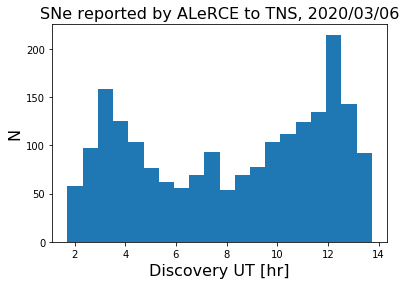

In [45]:
fig, ax = plt.subplots()
ax.hist(df.first_UT, bins=20)
ax.set_xlabel("Discovery UT [hr]", fontsize=16)
ax.set_ylabel("N", fontsize=16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE to TNS, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
plt.savefig("plots/discovery_UT.png")

print(np.mean(df.first_UT), np.std(df.first_UT))

### Histogram of RA DEC coordinates

In [46]:
import ephem

In [47]:
df["ecl_lat"] = df.apply(lambda row: np.rad2deg(ephem.Ecliptic(ephem.Equatorial('%s' % (row.ra / 15.), '%s' % row.dec, epoch=ephem.J2000)).lat), axis=1)

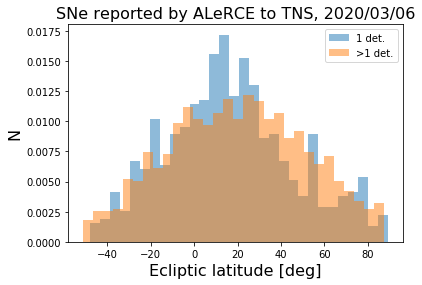

In [48]:
fig, ax = plt.subplots()
mask = df.nobs == 1
ax.hist(df.ecl_lat[mask], bins=30, label="1 det.", alpha=0.5, density=True)
ax.hist(df.ecl_lat[~mask], bins=30, label=">1 det.", alpha=0.5, density=True)
ax.legend()
ax.set_xlabel("Ecliptic latitude [deg]", fontsize=16)
ax.set_ylabel("N", fontsize=16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE to TNS, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
plt.savefig("plots/discovery_ecl_lat.png")


### Cumulative distribution of MJD times

SNe identified by ALeRCE (average 9.1 SN/day), 2020/03/06
2026
58690.1689815 58913.5266550998


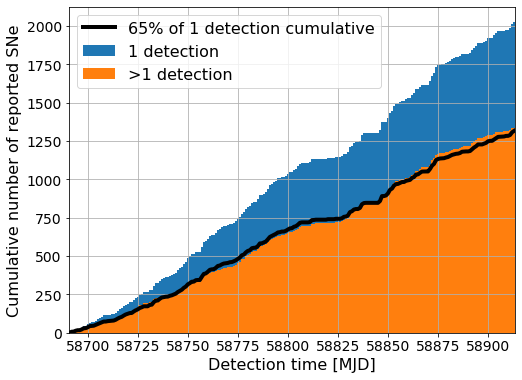

In [49]:
fig, ax = plt.subplots(figsize = (8, 6))
x, y, _ = ax.hist(df.first_mjd, bins = np.linspace(df.first_mjd.min(), df.first_mjd.max(), df.first_mjd.max() - df.first_mjd.min() + 1), cumulative = True, label="1 detection")
ax.set_xlabel("Detection time [MJD]", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("Cumulative number of reported SNe", fontsize = 16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE to TNS (average %.1f SN/day), %i/%02i/%02i" % 
                 (len(oids) / (df.first_mjd.max() - df.first_mjd.min()), now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE (average %.1f SN/day), %i/%02i/%02i" % 
                 (df.shape[0] / (df.first_mjd.max() - df.first_mjd.min()), now.year, now.month, now.day), fontsize = 16)
ax.set_title("")
print("SNe identified by ALeRCE (average %.1f SN/day), %i/%02i/%02i" % 
                 (df.shape[0] / (df.first_mjd.max() - df.first_mjd.min()), now.year, now.month, now.day))
efficiency = 0.65
plt.savefig("plots/firstmjd.png")
ax.hist(df[df.nobs > 1].first_mjd, bins = np.linspace(df.first_mjd.min(), df.first_mjd.max(), df.first_mjd.max() - df.first_mjd.min() + 1), cumulative = True, label=">1 detection")
ax.plot((y[:-1] + y[1:]) / 2, x * efficiency, c = 'k', label="%i%% of 1 detection cumulative" % (efficiency * 100.), lw=4)
ax.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.xlim([df.first_mjd.min(), df.first_mjd.max()])
plt.savefig("plots/firstmjd_efficiency_%s.png" % mode, bbox_inches="tight")
plt.savefig("plots/firstmjd_efficiency_%s.pdf" % mode, bbox_inches="tight")

print(len(df.first_mjd))
print(df.first_mjd.min(), df.first_mjd.max())

# Do mosaic of stamps

In [50]:
def plot_stamp(self, oid, candid=None):
    'plot stamp in a notebook given oid. It uses IPython HTML.'

    # if candid is None, get minimum candid                                                                                                                                                                    
    if candid is None:
        candid = min(self.get_detections(oid).index)

    science = "http://avro.alerce.online/get_stamp?oid=%s&candid=%s&type=science&format=png" % (oid, candid)
    images="""                                                                                                                                                                                                 
    <div>ZTF oid: %s, candid: %s</div>                                                                                                                                                                         
    <div>&emsp;&emsp;&emsp;&emsp;&emsp;                                                                                                                                                                        
    Science                                                                                                                                                                                                    
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;                                                                                                                                   
    Template                                                                                                                                                                                                   
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;                                                                                                                                   
    Difference                                                                                                                                                                                                 
    <div class="container">                                                                                                                                                                                    
    <div style="float:left;width:20%%"><img src="%s"></div>                                                                                                                                                    
    <div style="float:left;width:20%%"><img src="%s"></div>                                                                                                                                                    
    <div style="float:left;width:20%%"><img src="%s"></div>                                                                                                                                                    
    </div>                                                                                                                                                                                                     
    """ % (oid, candid, science, science.replace("science", "template"), science.replace("science", "difference"))
    display(HTML(images))


# Distribution of number of detections

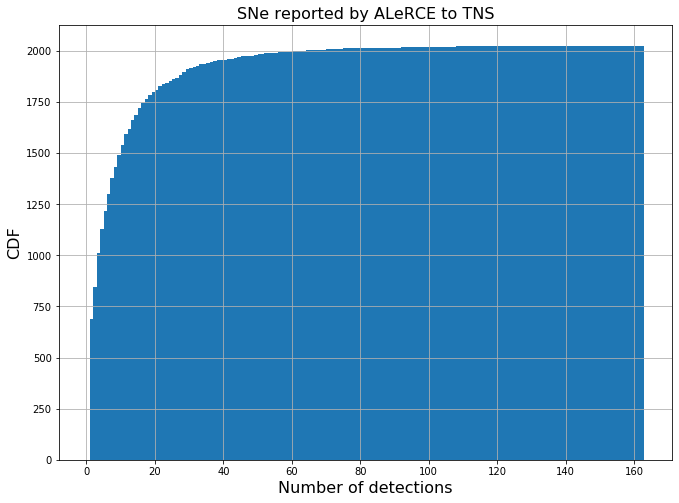

In [51]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.nobs, bins = np.linspace(0, df.nobs.max(), df.nobs.max() + 1), cumulative = True)
ax.set_xlabel("Number of detections", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("plots/nobs.png")

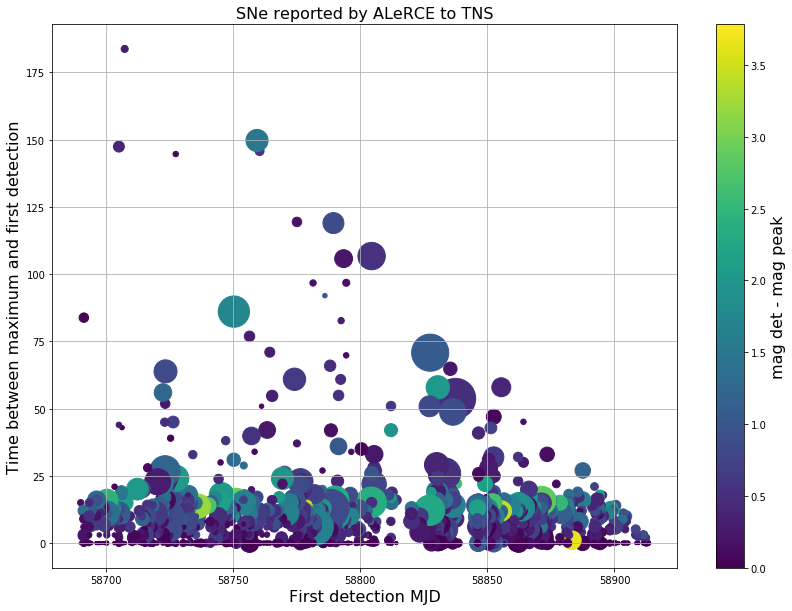

In [52]:
fig, ax = plt.subplots(figsize = (14, 10))
sc = ax.scatter(df.first_mjd, df.dt_first_max, s = 10 * df.nobs, c = df.dmag_first_max)
cbar = fig.colorbar(sc)
cbar.set_label("mag det - mag peak", fontsize=16)
ax.set_xlabel("First detection MJD", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("Time between maximum and first detection", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("plots/dt_first_max_firstMJD.png")

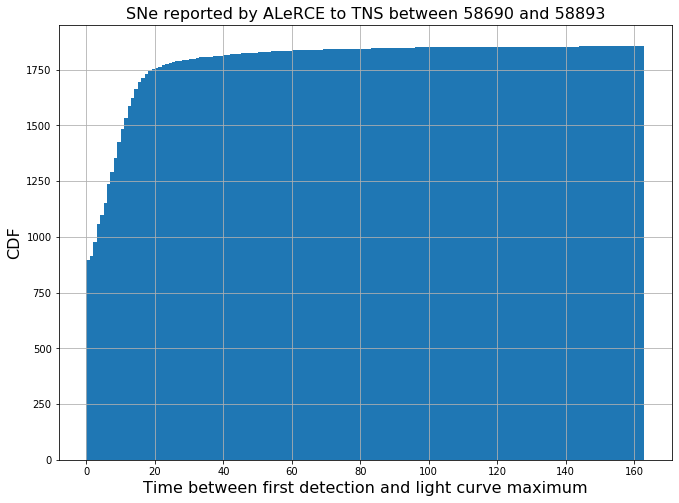

In [53]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.dt_first_max[df.first_mjd < df.first_mjd.max() - 20], bins = np.linspace(0, df.nobs.max(), df.nobs.max() + 1), cumulative = True)
ax.set_xlabel("Time between first detection and light curve maximum", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS between %i and %i" % (df.first_mjd.min(), df.first_mjd.max() - 20), fontsize = 16)
plt.savefig("plots/dt_first_mag.png")

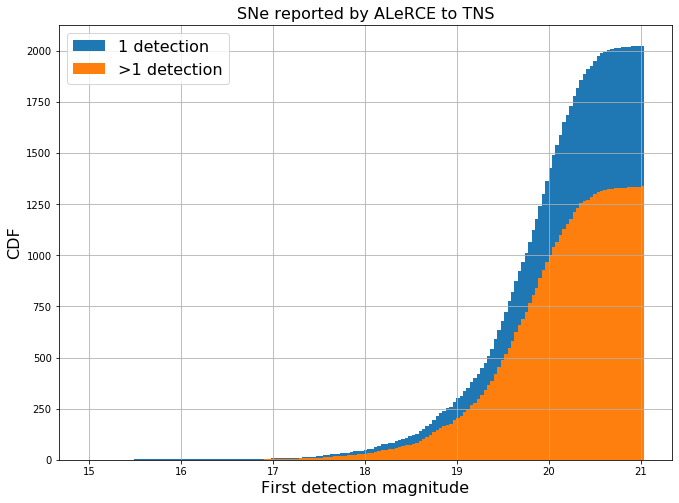

In [54]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1), cumulative = True, label="1 detection")
ax.hist(df[df.nobs > 1].first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1), cumulative = True, label=">1 detection")
ax.legend(fontsize=16)
ax.set_xlabel("First detection magnitude", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("plots/mags.png")

2026 SNe reported (excluding 21 retracted)
Average number of detections: 12
Median number of detections: 7
Fraction of candidates with >1 detections: 0.660415
SNe with time between 1st detection and last non-detection < 1 day: 279
SNe with time between 2nd detection and last non-detection < 1 day: 80
Average time between 1st detection and last non-detection: 4.32 [days]
Average time between 2nd detection and last non-detection: 8.53 [days]
STD time between 2nd detection and last non-detection: 3.91 [days]
STD time between 2nd detection and last non-detection: 10.38 [days]


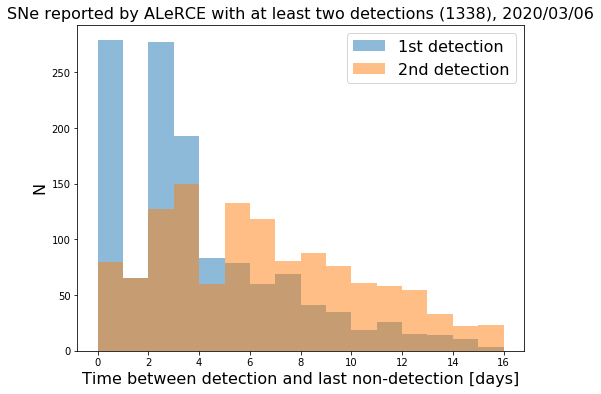

In [55]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.hist(df.dt[df.nobs > 1], alpha = 0.5, bins = np.linspace(0, 16, 17), label = "1st detection" )
ax.hist(df.dt2[df.nobs > 1], alpha = 0.5, bins = np.linspace(0, 16, 17), label = "2nd detection")
ax.set_xlabel("Time between detection and last non-detection [days]", fontsize = 16)
print("%i SNe reported (excluding %i retracted)" % (df.nobs.shape[0], len(retracted)))
print("Average number of detections: %i" % np.average(df.nobs[df.nobs > 1]))
print("Median number of detections: %i" % np.median(df.nobs[df.nobs > 1]))
print("Fraction of candidates with >1 detections: %f" % (np.sum(df.nobs > 1) / df.nobs.shape[0]))
print("SNe with time between 1st detection and last non-detection < 1 day: %i" % np.sum(df.dt[df.nobs > 1] < 1))
print("SNe with time between 2nd detection and last non-detection < 1 day: %i" % np.sum(df.dt2[df.nobs > 1] < 1))
print("Average time between 1st detection and last non-detection: %4.2f [days]" % np.mean(df.dt[df.nobs > 1]))
print("Average time between 2nd detection and last non-detection: %4.2f [days]" % np.mean(df.dt2[df.nobs > 1]))
print("STD time between 2nd detection and last non-detection: %4.2f [days]" % np.std(df.dt[df.nobs > 1]))
print("STD time between 2nd detection and last non-detection: %4.2f [days]" % np.std(df.dt2[df.nobs > 1]))
ax.set_ylabel("N", fontsize = 16)
ax.legend(fontsize = 16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day), fontsize = 16)
plt.savefig("plots/TimeSinceDetection_%s.png" % mode)
plt.savefig("plots/TimeSinceDetection_%s.pdf" % mode)

[7.9612963 0.0582291 2.9618634 ... 2.9940625 7.0421991 0.0276505]
2026 SNe reported (excluding 21 retracted)
Average number of detections: 12
Median number of detections: 7
Fraction of candidates with >1 detections: 0.660415
SNe with time between 1st detection and last non-detection < 1 day: 279
SNe with time between 2nd detection and last non-detection < 1 day: 80
Average time between 1st detection and last non-detection: 4.32 [days]
Average time between 2nd detection and last non-detection: 8.53 [days]
STD time between 2nd detection and last non-detection: 3.91 [days]
STD time between 2nd detection and last non-detection: 10.38 [days]
Title SNe reported by ALeRCE with at least two detections (1338), 2020/03/06


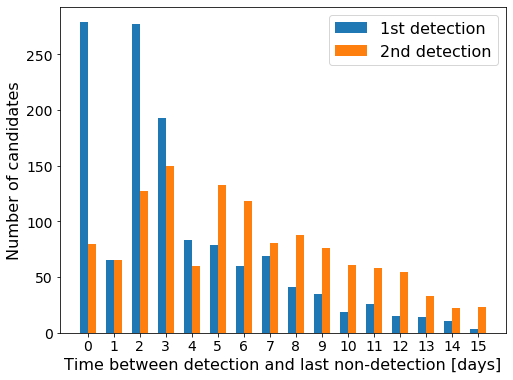

In [56]:
fig, ax = plt.subplots(figsize = (8, 6))
bins = np.linspace(0, 16, 17)
print(df.dt[df.nobs > 1].values)
h1, _ = np.histogram(df.dt[df.nobs > 1].values, bins=bins)
h2, _ = np.histogram(df.dt2[df.nobs > 1].values, bins=bins)
width = 0.3
h1_x = bins - 0.15
h2_x = bins + 0.15
ax.bar(h1_x[0:-1], h1, width=width, label="1st detection")
ax.bar(h2_x[0:-1], h2, width=width, label="2nd detection")
plt.tick_params(labelsize=14)
ax.set_xticks(bins[:-1])

ax.set_xlabel("Time between detection and last non-detection [days]", fontsize = 16)
print("%i SNe reported (excluding %i retracted)" % (df.nobs.shape[0], len(retracted)))
print("Average number of detections: %i" % np.average(df.nobs[df.nobs > 1]))
print("Median number of detections: %i" % np.median(df.nobs[df.nobs > 1]))
print("Fraction of candidates with >1 detections: %f" % (np.sum(df.nobs > 1) / df.nobs.shape[0]))
print("SNe with time between 1st detection and last non-detection < 1 day: %i" % np.sum(df.dt[df.nobs > 1] < 1))
print("SNe with time between 2nd detection and last non-detection < 1 day: %i" % np.sum(df.dt2[df.nobs > 1] < 1))
print("Average time between 1st detection and last non-detection: %4.2f [days]" % np.mean(df.dt[df.nobs > 1]))
print("Average time between 2nd detection and last non-detection: %4.2f [days]" % np.mean(df.dt2[df.nobs > 1]))
print("STD time between 2nd detection and last non-detection: %4.2f [days]" % np.std(df.dt[df.nobs > 1]))
print("STD time between 2nd detection and last non-detection: %4.2f [days]" % np.std(df.dt2[df.nobs > 1]))
ax.set_ylabel("Number of candidates", fontsize = 16)
ax.legend(fontsize = 16)
#if mode=="tns":
#    ax.set_title("SNe reported by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day), fontsize = 16)
#elif mode=="all":
#    ax.set_title("SNe identified by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day), fontsize = 16)
print("Title", "SNe reported by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day))
plt.savefig("plots/TimeSinceDetection_%s.png" % mode, bbox_inches="tight")
plt.savefig("plots/TimeSinceDetection_%s.pdf" % mode, bbox_inches="tight")

# Show number of SNe with a lower non-detection in the same filter within the last 25 hr

In [ ]:
fig, ax = plt.subplots(figsize = (11, 8))
lasthr = 25.
mask = (df.dmag_fid.notna())  & (df.dmag_fid > 0.5) & (df.dt_fid <= lasthr / 24.) & (df.nobs > 1)
ax.hist(df.dmag_fid[mask], alpha = 1, bins=10)# cumulative=True)#,
        #label = "%s SNe @ %i/%02i/%02i" % (mask.sum(), now.year, now.month, now.day))#, cumulative=True)
#ax.set_xlabel("Time between detection and last non-detection [days]", fontsize = 16)
#print("%i SNe reported (excluding %i retracted)" % (df.nobs.shape[0], len(retracted)))
#print("Average number of detections: %i" % np.average(df.nobs[df.nobs > 1]))
#print("Median number of detections: %i" % np.median(df.nobs[df.nobs > 1]))
#print("Fraction of candidates with >1 detections: %f" % (np.sum(df.nobs > 1) / df.nobs.shape[0]))
#print("SNe with time between 1st detection and last non-detection < 1 day: %i" % np.sum(df.dt[df.nobs > 1] < 1))
#print("SNe with time between 2nd detection and last non-detection < 1 day: %i" % np.sum(df.dt2[df.nobs > 1] < 1))
#print("Median time between 1st detection and last non-detection: %4.2f [days]" % np.median(df.dt[df.nobs > 1]))
#print("Median time between 2nd detection and last non-detection: %4.2f [days]" % np.median(df.dt2[df.nobs > 1]))
ax.set_xlabel("Last non-detection - detection magnitudes", fontsize = 16)
ax.set_ylabel("N", fontsize = 16)
ax.set_title("SNe with non-detection within last %i hr of 1st detection in the same filter" % (lasthr), fontsize = 16)
#ax.legend(fontsize=16, loc = 1)
plt.savefig("plots/Deltamag.png")
plt.savefig("plots/Deltamag.pdf")
print(df.loc[mask & (df.dmag_fid > 1)].index)


fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(df.dmag_fid[mask], df.first_det_mag[mask], c = df.mag_at_max[mask], s=70)
cbar = fig.colorbar(sc, ticks =[18, 18.5, 19, 19.5, 20])
cbar.set_label('Minimum magnitude', fontsize=16)
cbar.ax.tick_params(which='major',labelsize=16)
ax.set_xlabel("Last non-detection - detection magnitudes", fontsize = 16)
ax.set_ylabel("First detection magnitude", fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("plots/mag_dmag.png")

for oid in mask[mask].index:
    display(HTML("<a href='http://alerce.online/object/%s'> %s <a>" % (oid, oid)))

In [ ]:
mask =  (df.dmdt_fid.notna()) & (df.dmdt_fid > 0.5) & (df.dmdt_fid < 20) & (df.dmag_fid > 0.5)  & (df.nobs>1)
print(mask.sum())

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(df.dmdt_fid[mask], df.first_det_mag[mask], c = df.mag_at_max[mask], s=70)
cbar = fig.colorbar(sc)#, ticks =[17, 17.18, 18.5, 19, 19.5, 20])
cbar.set_label('Minimum magnitude', fontsize=18)
cbar.ax.tick_params(which='major',labelsize=16)
ax.set_xlabel(r"$|\Delta m/ \Delta t|$   [mag/day]", fontsize = 18)
ax.set_ylabel("First detection magnitude", fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.savefig("plots/dmdt.png")

for oid in mask[mask].index:
    display(HTML("<a href='http://alerce.online/object/%s'> %s <a>" % (oid, oid)))

In [ ]:
oid = 'ZTF19abueupg'#'ZTF19abvdgqo'
det = alerce.get_detections(oid, format='pandas')
nondet = alerce.get_non_detections(oid, format='pandas')
fig, ax = plt.subplots(figsize=(8,6))
colors = {1: 'g', 2: 'r'}
mjd0 = det.mjd.min()
for fid in [1, 2]:
    mask = det.fid == fid
    ax.errorbar(det.mjd[mask] - mjd0, det.magpsf[mask], yerr=det.sigmapsf[mask], marker='o', lw=0, elinewidth=1, c=colors[fid], label="%s mag" % colors[fid])
    mask = (nondet.fid == fid) & (nondet.index < det.mjd.min())
    ax.scatter(nondet.index[mask] - mjd0, nondet.diffmaglim[mask], marker='v', c=colors[fid], alpha=0.5, label="mag.lim. %s" % colors[fid])
ax.set_ylim(ax.get_ylim()[1], 18.3)
ax.set_xlim(-10, 20)
ax.tick_params(axis='both', which='major', labelsize=16)
#ax.tick_params(axis='y', which='major', labelsize=16)
ax.set_xlabel("Time since first detection [days]", fontsize=18)
ax.set_ylabel("mag", fontsize=18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=16, loc=4)
plt.tight_layout()
plt.savefig("BestSN.png")

# Find distribution of time between detection and 5th detection in the same band

In [ ]:
mask = (df.nobs > 5)
dt_5th = {}
for oid in df[mask].index:
    mask = all_detections.oid == oid
    for fid in all_detections[mask].fid.unique():
        mask = (all_detections.oid == oid) & (all_detections.fid == fid)
        if mask.sum() == 0:
            continue
        fid_mjds = all_detections[mask].mjd.values
        if len(fid_mjds) > 4:
            if oid in dt_5th.keys():
                dt_5th[oid] = min(dt_5th[oid], fid_mjds[4] - df.loc[oid].first_mjd)
            else:
                dt_5th[oid] = fid_mjds[4] - df.loc[oid].first_mjd

In [ ]:
fig, ax = plt.subplots()
ax.hist(dt_5th.values(), bins=25)
print(np.percentile(np.array(list(dt_5th.values())), 5))
print(np.median(np.array(list(dt_5th.values()))))
print(np.percentile(np.array(list(dt_5th.values())), 95))
len(dt_5th)

In [ ]:
mask = (df.nobs > 5) & (df.dmag_fid > 0) & (df.dt_fid <= lasthr / 24.)
ax.hist(df.dmag_fid[mask].dropna(), alpha = 0.5, bins=20, label = "%s SNe @ %i/%02i/%02i" % (mask.sum(), now.year, now.month, now.day))
#ax.set_xlabel("Time between detection and last non-detection [days]", fontsize = 16)
#print("%i SNe reported (excluding %i retracted)" % (df.nobs.shape[0], len(retracted)))
#print("Average number of detections: %i" % np.average(df.nobs[df.nobs > 1]))
#print("Median number of detections: %i" % np.median(df.nobs[df.nobs > 1]))
#print("Fraction of candidates with >1 detections: %f" % (np.sum(df.nobs > 1) / df.nobs.shape[0]))
#print("SNe with time between 1st detection and last non-detection < 1 day: %i" % np.sum(df.dt[df.nobs > 1] < 1))
#print("SNe with time between 2nd detection and last non-detection < 1 day: %i" % np.sum(df.dt2[df.nobs > 1] < 1))
#print("Median time between 1st detection and last non-detection: %4.2f [days]" % np.median(df.dt[df.nobs > 1]))
#print("Median time between 2nd detection and last non-detection: %4.2f [days]" % np.median(df.dt2[df.nobs > 1]))
ax.set_xlabel("Last non-detection - detection magnitudes", fontsize = 16)
ax.set_ylabel("N", fontsize = 16)
ax.set_title("Rising SNe reported by ALeRCE, non-det. within last %i hr of 1st det. in same filter" % (lasthr), fontsize = 16)
ax.legend(fontsize=16, loc = 1)
plt.savefig("plots/Deltamag.png")
plt.savefig("plots/Deltamag.pdf")
print(df.loc[mask & (df.dmag_fid > 1)].index)

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.models import ColumnDataSource, OpenURL, TapTool

output_notebook()

In [ ]:
df["nobs_t"] = 5 + df.nobs
df["dmdt"] = df.dmag_fid / df.dt_fid

In [ ]:
from bokeh.palettes import Spectral10
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap


p = figure(
    plot_width = 800,
    plot_height = 600,
    tools=('pan, wheel_zoom, box_zoom, reset, tap')
)
p.add_tools(HoverTool(tooltips="""
<div>
    <div><span style='font-size: 12px'>oid: @oid</span></div>    
    <div><span style='font-size: 12px'>nobs: @nobs</span></div>    
    <div><span style='font-size: 12px'>dt: @dt</span></div>    
    <div><span style='font-size: 12px'>dt2: @dt2</span></div>    
    <div><span style='font-size: 12px'>dt_fid: @dt_fid</span></div>
    <div><span style='font-size: 12px'>dmag_fid: @dmag_fid</span></div>
    <div><span style='font-size: 12px'>first_mjd: @first_mjd</span></div>
    <div><span style='font-size: 12px'>dmdt: @dmdt</span></div>

</div>
"""))

taptool = p.select(type = TapTool)
url = "http://dev.alerce.online/vue/object/@oid"
taptool.callback = OpenURL(url=url)

color_col = 'first_mjd'
mapper = linear_cmap(field_name=color_col, palette=Viridis256,low=df.first_mjd.min(), high=df.first_mjd.max())

x_col = 'dt_fid'
y_col = 'dmag_fid'
size_col = 'nobs_t'
p.circle(
    x_col,
    y_col,
    source = df,
    color = mapper,
    size = size_col,
    line_alpha = 0.6,
    fill_alpha = 0.6
)

p.xaxis.axis_label = x_col
p.yaxis.axis_label = y_col
p.title.text = ("%s vs %s (size: %s, color: %s)" % (x_col, y_col, size_col, color_col))
show(p)


In [ ]:
from bokeh.palettes import Spectral10
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap


p = figure(
    plot_width = 1000,
    plot_height = 600,
    tools=('pan, wheel_zoom, box_zoom, reset, tap')
)
p.add_tools(HoverTool(tooltips="""
<div>
    <div><span style='font-size: 12px'>oid: @oid</span></div>    
    <div><span style='font-size: 12px'>nobs: @nobs</span></div>    
    <div><span style='font-size: 12px'>dt: @dt</span></div>    
    <div><span style='font-size: 12px'>dt2: @dt2</span></div>    
    <div><span style='font-size: 12px'>dt_fid: @dt_fid</span></div>
    <div><span style='font-size: 12px'>dmag_fid: @dmag_fid</span></div>
    <div><span style='font-size: 12px'>first_mjd: @first_mjd</span></div>
    <div><span style='font-size: 12px'>dmdt: @dmdt</span></div>

</div>
"""))

taptool = p.select(type = TapTool)
url = "http://alerce.online/vue/object/@oid"
taptool.callback = OpenURL(url=url)

color_col = 'dmag_first_max'
mapper = linear_cmap(field_name=color_col, palette=Viridis256,low=df.dmag_first_max.min(), high=df.dmag_first_max.max())


x_col = 'first_mjd'
y_col = 'dt_first_max'
size_col = 'nobs_t'
p.circle(
    x_col,
    y_col,
    source = df,
    color = mapper,
    size = size_col,
    line_alpha = 0.6,
    fill_alpha = 0.6
)

p.xaxis.axis_label = x_col
p.yaxis.axis_label = y_col
p.title.text = ("%s vs %s (size: %s, color: %s)" % (y_col, x_col, size_col, color_col))
show(p)


In [ ]:
from bokeh.palettes import Spectral10
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap


p = figure(
    plot_width = 800,
    plot_height = 600,
    tools=('pan, wheel_zoom, box_zoom, reset, tap')
)
p.add_tools(HoverTool(tooltips="""
<div>
    <div><span style='font-size: 12px'>oid: @oid</span></div>    
    <div><span style='font-size: 12px'>nobs: @nobs</span></div>    
    <div><span style='font-size: 12px'>dt: @dt</span></div>    
    <div><span style='font-size: 12px'>dt2: @dt2</span></div>    
    <div><span style='font-size: 12px'>dt_fid: @dt_fid</span></div>
    <div><span style='font-size: 12px'>dmag_fid: @dmag_fid</span></div>
    <div><span style='font-size: 12px'>first_mjd: @first_mjd</span></div>
    <div><span style='font-size: 12px'>dmdt: @dmdt</span></div>

</div>
"""))

taptool = p.select(type = TapTool)
url = "http://dev.alerce.online/vue/object/@oid"
taptool.callback = OpenURL(url=url)

#sc = ax.scatter(df.dmdt_fid[mask], df.first_det_mag[mask], c = df.mag_at_max[mask], s=70)

mask =  (df.dmdt_fid.notna()) & (df.dmdt_fid > 0.2) & (df.dmdt_fid < 20) & (df.dmag_fid > 0.5)  & (df.nobs>1)
color_col = 'mag_at_max'
mapper = linear_cmap(field_name=color_col, palette=Viridis256,low=df[mask][color_col].min(), high=df[mask][color_col].max())

x_col = 'dmdt_fid'
y_col = 'first_det_mag'
size_col = 'dmag_first_max'
p.circle(
    x_col,
    y_col,
    source = df.loc[mask],
    color = mapper,
    size = 20,
    line_alpha = 0.6,
    fill_alpha = 0.6
)

p.xaxis.axis_label = x_col
p.yaxis.axis_label = y_col
p.title.text = ("%s vs %s (size: %s, color: %s)" % (x_col, y_col, size_col, color_col))
show(p)


In [ ]:
mask.sum()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(df.first_mjd, df.nobs)
ax.set_yscale("log")

In [ ]:
(df.dec < 30).sum() /  (df.dec < 90).sum()

In [ ]:
fig, ax = plt.subplots()
mask = df.dmag > 0
ax.hist(df.nobs[df.dec < 15], cumulative=True, alpha=0.5, label = "dec < 20")
ax.hist(df.nobs[df.dec < 30], cumulative=True, alpha=0.5, label = "dec < 30")
ax.hist(df.nobs[df.dec < 90], cumulative=True, alpha=0.5, label = 'all')
plt.legend()

# Obtain TNS stats (scrapping)

In [ ]:
#results = {}
#specs = {}
#for name in all_alerce.Name.values:
#    objname = name[3:]
#    print(objname, len(results))
#    url = "https://wis-tns.weizmann.ac.il/object/%s" % objname
#    response = requests.get(url)
#    results[objname] = re.findall("cell-time_received.>(.*?)<.*cell-user_name.>(.*?)<.*cell-source_group_name.>(.*?)<.*cell-discovery_date.>(.*?)<.*", response.text)[1:]
#    specs[objname] = re.findall("spectrum.*?cell-id.>.*?cell-obsdate.>(.*?)<.*cell-tel_inst.>(.*?)<.*cell-exptime.>(.*?)<.*cell-observer.>(.*?)<.*", response.text)[1:]

### Save results

In [ ]:
#import pickle
#with open('wis_results.pkl', 'wb') as handle:
#    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('wis_specs.pkl', 'wb') as handle:
#    pickle.dump(specs, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load results

In [ ]:
import pickle
results = pickle.load(open('wis_results.pkl', 'rb'))
specs = pickle.load(open('wis_specs.pkl', 'rb'))

In [ ]:
for SN in list(specs.keys()):
    if specs[SN] == []:
        del specs[SN]

In [ ]:
delta_report = []
delta_2ndreport = []
group_2ndreport = []
delta_clf = []
mjd_disc = []
for SN in results.keys():
    #if not SN in specs.keys():
    #    continue
    report_2nd = 1e99
    clf_date = 1e99
    if len(results[SN]) > 0:
        for r in results[SN]:
            report_day = Time(r[0].replace(" ", "T")).mjd
            disc_day = Time(r[3].replace(" ", "T")).mjd
            disc_group = r[1]
            if disc_group == "ALeRCE":
                first_detection = disc_day
                report_ALeRCE = report_day
                delta_report.append(report_day - first_detection)
                mjd_disc.append(disc_day)
                if SN in specs.keys():
                    if specs[SN] != []:
                        clf_day = Time(specs[SN][0][0].replace(" ", "T")).mjd
                        delta_clf.append(clf_day - first_detection)
            else:
                if report_day < report_2nd:# and disc_group[:3] == "ZTF" :
                    report_2nd = report_day
                    report_group = disc_group
    if report_2nd < 1e99:
        delta_2ndreport.append(report_2nd - first_detection)
        group_2ndreport.append((SN, report_group))
                
                
delta_report = np.array(delta_report)
delta_2ndreport = np.array(delta_2ndreport)
mjd_disc = np.array(mjd_disc)

In [ ]:
cl, n = np.unique(np.array(group_2ndreport)[:, 1], return_counts=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(cl, n)
plt.xticks(rotation=90)
ax.set_title("Sources of subsequent TNS reports")
plt.tight_layout()
plt.savefig("plots/OtherSources.png")

In [ ]:
fig, ax = plt.subplots()
ax.scatter(mjd_disc, delta_report)#, bins=100, cumulative=True);

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
refmjd = 58696
ax.hist(delta_report[mjd_disc > refmjd] * 24., bins=1000, cumulative=True, density=True);
ax.set_title("Candidates submitted to TNS since %i/%02i/%02i (%i)" %
             (Time(refmjd, format='mjd').datetime.year,
              Time(refmjd, format='mjd').datetime.month,
              Time(refmjd, format='mjd').datetime.day,
              len(delta_report[mjd_disc > 58697])), fontsize=18)
ax.set_xlabel("Time between ZTF first detection and ALeRCE report to TNS [hr]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
plt.savefig("plots/Report_times.png")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(delta_2ndreport, bins=1000, cumulative=True, density=True);
ax.set_title("Candidates with 2nd report to TNS (%i)" % len(delta_2ndreport), fontsize=18)
ax.set_xlabel("Time between ALeRCE report to TNS and subsequent report [days]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
plt.savefig("plots/ALeRCE_vs_rest.png")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(delta_clf, bins=1000, density=True, cumulative=True);
ax.set_title("Candidates with spectroscopic classification (%i)" % len(delta_clf), fontsize=18)
ax.set_xlabel("Time between ALeRCE report to TNS and spec. classification [days]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
plt.savefig("plots/ALeRCE_classification.png")

In [ ]:
print(np.median(delta_report[mjd_disc > refmjd]))

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.hist(delta_report[mjd_disc > refmjd], bins=1000, density=True, alpha=0.5, cumulative=True, color = 'r', label='ALeRCE');
ax.hist(delta_2ndreport, bins=1000, density=True, alpha=0.5, cumulative=True, label='Other', color = 'gray');
ax.hist(delta_clf, bins=1000, density=True, alpha=0.5, cumulative=True, label='Spectra', color = 'b');
ax.axvline(np.median(delta_report[mjd_disc > refmjd]), c = 'r')
ax.text(np.median(delta_report[mjd_disc > refmjd]), 1.,
        " %.1f hr" % (np.median(delta_report[mjd_disc > refmjd]) * 24.), color = 'r', fontsize=20)
ax.axvline(np.median(delta_2ndreport), c = 'gray')
ax.text(np.median(delta_2ndreport), 1.,
        " %.1f days" % (np.median(delta_2ndreport)), color = 'gray', fontsize=20, rotation=90, ha = 'right')
ax.axvline(np.median(delta_clf), c = 'b')
ax.text(np.median(delta_clf), 1.,
        " %.1f days" % (np.median(delta_clf)), color = 'b', fontsize=20, rotation=90, ha = 'right')
ax.set_title("Candidates sent by ALeRCE", fontsize=18)
ax.set_xlabel("Time between first ZTF detection and report to TNS [days]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
ax.set_xlim(0, 25)
ax.legend(fontsize=18, loc=4)
plt.savefig("plots/ALeRCE_Other.pdf")
plt.savefig("plots/ALeRCE_Other.png")

In [ ]:
list(zip(group_2ndreport, delta_2ndreport))

In [ ]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1),
        cumulative = True, label="1 detection", density=True, alpha = 0.5, histtype='step', lw=2)
ax.hist(df[df.nobs > 1].first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1),
        cumulative = True, label=">1 detection", density=True, alpha = 0.5, histtype='step', lw=2)
ax.hist(all_alerce.loc[classified_mask]["Discovery Mag"], bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1),
        cumulative = True, label="spectroscopically classified", density=True, alpha = 0.5, histtype='step', lw=2)
ax.legend(fontsize=16, loc=2)
ax.set_xlabel("First detection magnitude", fontsize = 16)
#ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("plots/mags+clf.png")

In [ ]:
all_alerce["shortname"] = all_alerce.Name.apply(lambda x: x[3:])

In [ ]:
list(all_alerce)

# Do some statistics on ML classified objects

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets

In [ ]:
#!pip install psycopg2-binary
import psycopg2

In [ ]:
import json
credentials_file = "../usecases/alercereaduser_v2.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

In [ ]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

In [ ]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

In [ ]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

In [ ]:
query = "select * from class"
classes = pd.read_sql_query(query, conn)
classmapper = dict(zip(classes.name.tolist(), classes.id.tolist()))
classmapper

In [ ]:
fig, ax = plt.subplots(figsize=(20, 12))
ncl = 0
df_cl = {}
for cl in classmapper.keys():
    if cl in ["Other", "EB", "SNe", "AGN", "SN", "Variable Star", "Asteroid", "Bogus"]:
        continue
    ncl += 1
    print(cl)
    prob_name = "%s_prob" % cl.replace(" ", "")
    if cl == "AGN I":
        prob_name = "AGN-I_prob"
    elif cl == "EB/SD/D":
        prob_name = "EBSD/D_prob"
    elif cl == "EB/C":
        prob_name = "EBC_prob"
    elif cl == "Periodic/Other":
        prob_name = "Periodic-Other_prob"
    query='''
    select late_probabilities_v2."%s"
    from late_probabilities_v2 

    inner join objects
    on late_probabilities_v2.oid=objects.oid

    where objects.classrf=%i
    
    ''' % (prob_name, classmapper[cl])
    # notar que "SNIa_prob" is written between parenthesis, since this is a programatically defined column in SQL

    df_cl[prob_name] = pd.read_sql_query(query, conn)
    ax.hist(df_cl[prob_name][prob_name], histtype='step', cumulative=True, bins=20, lw=5, label=cl, alpha=0.8)
    ax.text(df_cl[prob_name][prob_name].max(), df_cl[prob_name].shape[0], cl, fontsize=18, rotation=45, va='bottom', ha='left')
ax.legend(fontsize=18)
ax.set_xlim(0, 1.2)
ax.set_yscale('log')
ax.set_xlabel("Probability")
ax.set_xlabel("CDF")
plt.savefig("plots/cumulative.png")    

In [ ]:
fig, ax = plt.subplots(nrows = len(df_cl.keys()), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(df_cl.keys()):
    print(idx, cl, np.percentile(df_cl[cl][cl], 5.))
    ax[idx].axvline(np.percentile(df_cl[cl][cl], 5.), c='g')
    ax[idx].axvline(np.percentile(df_cl[cl][cl], 50.), c='r')
    ax[idx].axvline(np.percentile(df_cl[cl][cl], 95.), c='g')

    ax[idx].axvline(1/len(df_cl.keys()), c = 'k')
    ax[idx].hist(df_cl[cl][cl], density=True, bins=40, lw=5, label=cl, alpha=0.8)
    ax[idx].text(df_cl[cl][cl].max(), 1., " %s (%i)" % (cl, df_cl[cl].shape[0]), fontsize=18, va='bottom', ha='left')

#ax[-1].set_xlabel("probability")    

# Build histogram given probability cut

In [ ]:
class_order = ['AGN-I', 'Blazar', 'CV/Nova', 'LPV', 'SNIa', 'SNIbc', 'SNII', 'SNIIn',
               'SLSN', 'EBSD/D', 'EBC', 'DSCT', 'RRL', 'Ceph', 'Periodic-Other']

In [ ]:
for prob_lim in np.linspace(0, 1, 100):
    fig, ax = plt.subplots(figsize=(12, 10))

    counts = {}
    for idx, cl in enumerate(class_order[::-1]):
        cl = "%s_prob" % cl
        mask = df_cl[cl][cl] > prob_lim
        if mask.sum() > 0:
            counts[cl] = len(df_cl[cl][cl].loc[mask])
            ax.text(counts[cl], idx, counts[cl])
        else:
            counts[cl] = 1e-3

    ax.barh(range(len(counts.keys())), list(counts.values()))
    ax.set_xscale('log')
    ax.set_xlim(0.5, ax.get_xlim()[1])
    ax.yaxis.set_ticks(range(len(counts.keys())))
    ax.yaxis.set_ticklabels([x[:-5] for x in counts.keys()]);
    ax.set_title("Minimum probability: %.2f" % prob_lim)
    
    plt.savefig("histogram_minprob%.2f.png" % prob_lim)

In [ ]:
supernova = {
        "internal_name": "ZTF19abyikbv"
        }

# construct list of (key,value) pairs
json_data = [('api_key', (None, api_key)),
            ('data', (None, json.dumps(supernova)))]

json_url = url_tns_api + '/get/search'
response = requests.post(json_url, files = json_data)

objname = response.json()["data"]["reply"][0]["objname"]
data = {
        "objname": objname,
        "photometry": "1",
        "spectra": "0"
        }

# construct list of (key,value) pairs
json_data = [('api_key', (None, api_key)),
            ('data', (None, json.dumps(data)))]

json_url = url_tns_api + '/get/object'
response = requests.post(json_url, files = json_data)

groupname = response.json()["data"]["reply"]["source_group"]["group_name"]
photometry = response.json()["data"]["reply"]["photometry"]

# Extract data from TNS (API approach)

# Sandbox or real

In [ ]:
sandbox = False # True: test in sandbox, False: send to real website

# Get API key and url

In [ ]:
if sandbox:
    print("Getting API sandbox key...")
    api_key = open("API_sandbox.key", "r").read()
else:
    print("Getting API key...")
    api_key = open("API.key", "r").read()
    
if sandbox:
    url_tns_api="https://sandbox-tns.weizmann.ac.il/api"
else:
    url_tns_api="https://wis-tns.weizmann.ac.il/api"
    
if not sandbox:
    print("WARNING: submitting to real (not sandbox) TNS website")

In [ ]:
# function for changing data to json format
def format_to_json(source):
    # change data to json format and return
    parsed = json.loads(source, object_pairs_hook = OrderedDict)
    result = json.dumps(parsed, indent = 4)
    return result

In [ ]:
mask = all_alerce["Discovering Group/s"] != "ALeRCE"

In [ ]:
dtALeRCE = {}
telescope_2ndreport = {}

for name in all_alerce.loc[mask].Name.values:
    objname = name[3:]
    data = {
            "objname": objname,
            "photometry": "1",
            "spectra": "0"
            }

    # construct list of (key,value) pairs
    json_data = [('api_key', (None, api_key)),
                ('data', (None, json.dumps(data)))]

    json_url = url_tns_api + '/get/object'
    response = requests.post(json_url, files = json_data)

    groupname = response.json()["data"]["reply"]["source_group"]["group_name"]
    photometry = response.json()["data"]["reply"]["photometry"]
    
    times = []
    telescopes = []
    for i in photometry:
        if i["remarks"][:20] != "[Last non detection]":
            print("   ", objname, i["jd"], i["remarks"], i["telescope"]["name"])
            times.append(float(i["jd"]))
            telescopes.append(i["telescope"]["name"])

    try:
        times = np.array(times)
        telescopes = np.array(telescopes, dtype=str)
        idxsorted = np.argsort(times)
        times = times[idxsorted]
        telescopes = telescopes[idxsorted]
        dtimes = times - times[0]
        mask_rep = (dtimes > 0.5) # remove repetitions within the same night 
        dtimes = dtimes[mask_rep]
        telescopes = telescopes[mask_rep]
        dtALeRCE[objname] = dtimes[0]
        telescope_2ndreport[objname] = telescopes[0]
        print(objname, dtALeRCE[objname], telescope_2ndreport[objname])
        
        if telescope_2ndreport[objname] == "P48":
            print(times, telescopes)
    except:
        print("Error with object %s" % objname)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.hist(dtALeRCE.values(), bins=np.linspace(0, 20, 21));
ax.set_xlabel("Report time difference (other - ALeRCE) [days]", fontsize=16);
ax.set_ylabel("N", fontsize=16)
plt.savefig("plots/Reportdiff.png")